In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', None)

In [2]:
data_path = '/home/sile2804/data-ceph/arguana/arg-generation/argument-undermining/'

In [4]:
jo_df =  pd.read_pickle(data_path + "jo_data/gen_data.pickle")

training_df = jo_df[jo_df.split =='train']
valid_df = jo_df[jo_df.split =='val']

In [4]:
training_df.head()

,post_id,split,comment_id,title,post,comment,n_sentences,direct_sents,all_4_sents,comment_sents,premise_counter_premise_pairs,num_attacks
0,t3_1u4mmo,train,t1_ceei4mi,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]","&gt;I believe that a church is like any other profit making business and therefore most pay similar taxes. I am not a religious person myself so I do not know the complete logistics of the revenue and spending of a church but I do understand they can yield a good amount of cash. \n\nChurches, like all other non-profits, must make money to continue to exist. The difference between a non-profit and a for-profit is that all profits in a non-profit go to expand the core mission whereas profits in a for-profit can be distributed to the owners. Do you want to eliminate deductions for all nonprofits, or only for religious ones?",4,"[0, 1]",[],"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., churches, like all other non profits, must make money to continue to exist., the difference between a non profit and a for profit is that all profits in a non profit go to expand the core mission whereas profits in a for profit can be distributed to the owners., do you want to eliminate deductions for all nonprofits, or only for religious ones?]","[[[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash.], churches, like all other non profits, must make money to continue to exist. the difference between a non profit and a for profit is that all profits in a non profit go to expand the core mission whereas profits in a for profit can be distributed to the owners. do you want to eliminate deductions for all nonprofits, or only for religious ones?]]",1
1,t3_1u4mmo,train,t1_ceemale,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]","&gt; I believe that a church is like any other profit making business and therefore most pay similar taxes.\n\nTo the contrary, churches are not businesses and aren't for profit. The simplest answer is that they aren't taxed because not-for-profit organizations get tax exemptions. A church could randomly decide one day that it was no longer interested in religion and only wants to be a not-for-profit charity and their tax situation would be the same.\n\nOf course, with the benefits of tax exempt status comes regulation -- for example, they are not supposed to be involved in political campaigning.",4,[0],[],"[i believe that a church is like any other profit making business and t

In [3]:
def convert_df(df, path, sample=None):
    examples = []
    if sample is not None:
        df = df.sample(sample)
    
    for idx, post in df.iterrows():
        for attack in post['premise_counter_premise_pairs']:
            examples.append(
                {
                    'conclusion': post['title'],
                    'premises': post['post'],
                    'weak_premises': attack[0],
                    'counter' : attack[1],
                }
            )
    
    print('Number of examples: {}'.format(len(examples)))
    new_df = pd.DataFrame(examples)
    return new_df
    #json.dump(examples, open(path, 'w'))

In [6]:
new_training_df = convert_df(training_df, '../data/train.json')

Number of examples: 90426


In [7]:
new_valid_df = convert_df(valid_df, '../data/valid.json')

Number of examples: 29940


In [12]:
new_training_df.to_pickle('../data/train.pkl')
new_valid_df.to_pickle('../data/valid.pkl')

In [10]:
new_training_df.to_csv('../data/train.csv', index=False)
new_valid_df.to_csv('../data/valid.csv', index=False)

### Prepare data for conclusion comprehension for CA generation task:

In [3]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

import nltk
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')

#from sentence_transformers import SentenceTransformer, util
#import torch
#model = SentenceTransformer('all-MiniLM-L6-v2')

In [15]:
def content_token_overlap(text1, text2):
    tokens1 = set([x for x in nltk.word_tokenize(text1.lower()) if x not in en_stopwords])
    tokens2 = set([x for x in nltk.word_tokenize(text2.lower()) if x not in en_stopwords])
    
    return round(len(tokens1.intersection(tokens2))/len(tokens1.union(tokens2)), 5)

In [8]:
df = pd.read_pickle(data_path + "jo_data/argument_rebuttals.pkl")

#### Test on a sample:

In [ ]:
sample_df = df.sample(1000)

In [11]:
#sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: process.extract(x['title'], x['post'], scorer=fuzz.token_set_ratio, limit=500), axis=1)
sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: [(sent, content_token_overlap(x['title'], sent)) for sent in x['post']], axis=1)

In [47]:
#Compute semantic similarity
sample_df['conclusion_embeddings'] = model.encode(sample_df['title'].tolist()).tolist()
sample_df['premises_embeddings'] = sample_df['post'].apply(lambda x: model.encode(x))
sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: util.pytorch_cos_sim(torch.tensor(x['conclusion_embeddings']), 
                                                                                      torch.tensor(x['premises_embeddings'])
                                                                ).tolist()[0], axis=1)
sample_df['conclusions_in_argument'] = sample_df.apply(lambda x: list(zip(x['post'], x['conclusions_in_argument'])), axis=1)

In [54]:
sample_df[['title', 'post', 'conclusions_in_argument']].head()

,title,post,conclusions_in_argument
290103,Shaming women for sleeping with many is no better than shaming men for sleeping with few,"[i see this a lot, where women say it's unfair to get shamed for sleeping around, but when men do they're praised for it, called a 'player', 'stud', etc., but nobody talks about how men get shamed for still being a virgin or 'not getting some', while women get praised for it., at the end of the day, aren't people getting shamed both ways for being themselves?, 'patriarchy' won't change my mind, as both are parties that are getting hurt., whether or not a guy being shamed is of the same gender that created the rules in the first place makes no difference to me, and i fail to see why it should., in my opinion, that's like saying people in the middle east shouldn't complain because their dictator shares the same nationality., the 'accusers' are both men and women as well, for either shaming., since both demographics are guilty of this, why should there be a difference?, going away for a bit, i'll probably read responses, though i can't promise to reply., thanks to everyone who took the effort to give me perspective!]","[(i see this a lot, where women say it's unfair to get shamed for sleeping around, but when men do they're praised for it, called a 'player', 'stud', etc., 0.5033611059188843), (but nobody talks about how men get shamed for still being a virgin or 'not getting some', while women get praised for it., 0.45310935378074646), (at the end of the day, aren't people getting shamed both ways for being themselves?, 0.32762911915779114), ('patriarchy' won't change my mind, as both are parties that are getting hurt., 0.33749765157699585), (whether or not a guy being shamed is of the same gender that created the rules in the first place makes no difference to me, and i fail to see why it should., 0.4704388380050659), (in my opinion, that's like saying people in the middle east shouldn't complain because their dictator shares the same nationality., 0.2672026753425598), (the 'accusers' are both men and women as well, for either shaming., 0.552834689617157), (since both demographics are guilty of this, why should there be a difference?, 0.336520254611969), (going away for a bit, i'll probably read responses, though i can't promise to reply., 0.10098472982645035), (thanks to everyone who took the effort to give me perspective!, 0.1411144733428955)]"
262589,"If you know your friend's significant other is cheating on her, you should not tell her.","[scenario: you have a close female friend., you find information that 100 demonstrates her significant other boyfriend, husband, girlfriend, wife is cheating on her., you should not tell her anything point blank., i once had a close friend whose boyfriend kept hitting on me for months., i finally told her., she didn't thank me., she said i was making it up because i wanted him for myself., she stopped speaking to me., a second time me and my friend karlie found out our friend's june's boyfriend was cheating and asking girls to come to his house to fuck him., we told june., june didn't believe us., we stayed friends but things got weird., third time broke the camel's back for me., i caught my best friend's boyfriend holding hands with another girl., i told her., he actually didn't deny it., they broke up., then she took him back., he was awkward around me afterwards., i know my experience may be anecdotal but 'shooting the messenger' is 100 real., people don't want to accept things that are painful., sometimes the truth is too painful to accept., instead of accepting it, they would rather shoot the messenger and hope that he she is lying rather than accept the truth., your friend is not going to want to believe her husband boyfriend is cheating., she's going to shoot you as the messenger., telling her risks damaging your friendship., 1 she's either not going to believe you., and or she'll turn it on you, shoot you as the messenger and that will affect your fri

In [55]:
similarity_dist = [cand[1] for cands in sample_df['conclusions_in_argument'].tolist() for cand in cands]

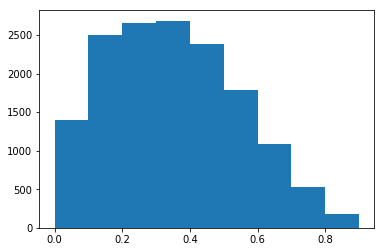

In [56]:
plt.hist(similarity_dist, bins=np.arange(0, 1, 0.1))
plt.show()

In [69]:
sample_df['top_conclusions_in_argument'] = sample_df['conclusions_in_argument'].apply(lambda item: [x for x in item if x[1] > 0.75])

In [70]:
len(sample_df[sample_df['top_conclusions_in_argument'].str.len() > 0])

294

In [71]:
sample_df[sample_df['top_conclusions_in_argument'].str.len() > 0][['title', 'top_conclusions_in_argument']].head(n=100)

,title,top_conclusions_in_argument
53431,I think Niccolo Machiavelli has an undeservedly poor reputation.,"[(it seems to me that niccolo machiavelli has an undeservedly poor legacy., 0.8205562829971313)]"
285839,I believe that sex education should be in the home from parents and not the jobs of educators at school.,"[(i think it shouldn t be the job of people at school to teach sex education because., 0.8578989505767822)]"
442976,"Dr. Phil and similar TV shows are the modern, socially acceptable equivalent of circus freak shows","[(shows like dr. phil are not much different from a freak show., 0.801140546798706)]"
435963,Transgender/trans-affirming people cannot define the word “man” or “woman”,"[(but so far, i have yet to hear a clear, meaningful definition of the term man or woman from someone who affirms transgenderism., 0.8030619025230408), (when i ask transgender trans affirming people for a definition, i typically get answers like this: a man is someone who says they are a man , a man is someone who experiences life as a man ., 0.7689554691314697)]"
392617,Nothing I can do as a cyclist will ever make drivers stop hating me.,"[(it seems like, no matter what i do, drivers will hate me and want me to stop riding., 0.7634909749031067), (i'm not going to stop, but it really feels like i'm doing everything that can be reasonably expected of a cyclist and drivers still hate me being on the road., 0.8047007322311401)]"
...,...,...
314122,Dark Souls isn’t as great of a game as everyone says it and the difficulty seems like a gimmick.,"[(i want to clarify a few things before i start: 1 i m in no way saying that dark souls is a bad game, just overrated., 0.7539910674095154), (now my argument is that the original dark souls is only rated so highly because a lot of mainstream games nowadays aren t very difficult., 0.782929003238678), (i do like it when a game is challenging but i m arguing that dark souls is only difficult because it creates unfair situations for the player., 0.8246773481369019)]"
41530,I believe a fetus has rights worth protecting.,"[(i simply believe that since there can be no informed decision made by the fetus, we have an obligation to protect it., 0.8215245008468628)]"
339971,"There should be no separate minimum wage for waiters or ""tipped"" employees. And tipping should not be a social ""expectation"" in pretty much every dining situation &amp; other places where tips are ""expected"" as a given. Waiters &amp; others should get paid a fair market wage by employers.","[(i think that waiters, hairdressers, valets, and other professions who have a tipping expectation should just be paid a fair market wage paid by their employers and there should be no pressure or expectation of tips from pretty much every customer., 0.8191947340965271)]"
467351,you have no moral obligation to disclose the fact that a meal is vegan to people eating it,"[(so, why should people have to 'disclose' that a meal is vegan?, 0.8401384949684143)]"


-----------

In [66]:
df = pd.read_pickle(data_path + "jo_data/argument_rebuttals.pkl")

In [67]:
df.head()

,post_id,split,comment_id,title,post,n_sentences,comment_sents
0,t3_1u4mmo,train,t1_ceehlbn,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]",4,"[i have heard this before ofc but when it is said louder than, or separate from the same issue when applied to corporations, or other non profits, i just think it's just religious discrimination., most, if not all corporations pay a much smaller percentage of their income in taxes than i do., why not focus on closing corporate loopholes first?, it would generate a lot more income than targeting religious institutions., why not focus on non religious nonprofits?, tons of those are shams where the head of said organization makes 7 figures., many are politically motivated, and actually are for profit in the sense that they are for changing laws and policies that allow third parties to become more profitable., i just don't have much respect for the taxing religions thing because you can apply the same arguments to different organizations resulting in higher tax revenue., i mean, sure., if some tv preacher is pulling in 7 figures selling 'prayer rags' then yeah, close whatever loopholes make that possible., but at the same time you have to close those same loopholes for non religious nonprofits, else it's just discrimination.]"
1,t3_1u4mmo,train,t1_ceei77d,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]",4,"[one of the historical methods of repressing out of favor religions is to make them pay exorbitant taxes., the blanket religious tax exemption is one of the ways we comply with the first amendment., many atheists seem to forget it guarantees the free exercise of religion in addition to forbidding the establishment of a state religion., taxing them like everyone else doesn't make sense because everyone else pays widely varying tax rates., should they be taxed as a commercial entity or an industrial one?, which subtype?, some religious practices involve wine., does that mean the churches will need permits taxes fees licenses as a resturant?, some christian sects consider the use of wine critical to the ceremony, others consider grape juice to be fine because it is symbolism., the rules and regulations answering those questions will burden some religions sects more than others., this then becomes a ripe area for both intentional and unintentional discrimination against out of favor religious groups., this will be hugely problematic for the free exercise clause., it is just as problematic for the establishment clause., as per the current justification for emminent domain, increased tax revenue is a justifying public good., taxing churches like everyone else would allow a state or locality to use eminent domain foreclosures in order to build a new mega church., the baptists catholics whoever will pay greater taxes than the mosque temple out of favor group currently on that corner., back to the wine exa

In [68]:
df['bot_comment'] = df.comment_sents.apply(lambda x:  'i am a bot, and this action was performed automatically.' in ' '.join(x))

In [69]:
df.bot_comment.value_counts()

False    539707
True       1971
Name: bot_comment, dtype: int64

In [70]:
df = df.drop(df[df.bot_comment].index)

In [71]:
df = df.rename(columns={
    'comment_sents' : 'counter',
})

##### Checking how many cases we have where the comment contains exactly the conclusion:

Based on the overlap between the comment and the conclusion:

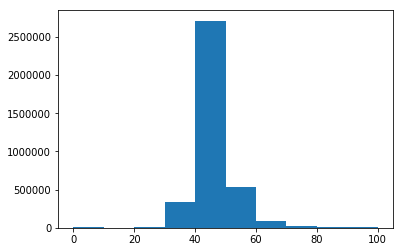

In [74]:
#compute overlap between the whole comment and the conclusion of the argument
df['conclusions_in_comment'] = df.apply(lambda x: process.extract(x['title'], x['counter'], scorer=fuzz.partial_ratio, limit=500), axis=1)
conc_sim_to_comment = [sent[1] for comment in df.conclusions_in_comment.tolist() for sent in comment]
plt.hist(conc_sim_to_comment)
plt.show()

In [82]:
df['top_conclusions_in_comment'] = df.conclusions_in_comment.apply(lambda l: [x for x in l if x[1] > 70])
df['count_of_conc_in_comments'] = df.top_conclusions_in_comment.apply(lambda l: len(l))

In [83]:
print('{} Rebuttal cases of {}'.format(len(df[df.count_of_conc_in_comments > 0]), len(df)))

30743 Rebuttal cases of 539707


In [84]:
df[df.count_of_conc_in_comments > 0][['title', 'post', 'counter']].head()

,title,post,counter
13,I believe that churches and other religious institutions should have to pay taxes.,"[i believe that a church is like any other profit making business and therefore most pay similar taxes., i am not a religious person myself so i do not know the complete logistics of the revenue and spending of a church but i do understand they can yield a good amount of cash., not entirely sure how accurate this article is, but it states that we could gain an additional 71 billion dollars per year and in a time where we as a country are in trillions of dollars of debt taxing a church seems reasonable to me., cmv]","[first, when religious institutions 'generate revenue', they are typically and by a vast majority doing this through donations of their followers., this is similar to how charities work., the donations are tax deductable for the person making the donation like charities., and many churches also provide free services for the community in the same way a charity would for example, my church has a 'meals on wheels' program that feeds the homeless ., by removing the tax exemption from religious institutions, it would be a small step to say that we should eliminate tax exemptions for charities as well., aside from that, if we treat churches and other religious institutions as companies that pay taxes, there will inevitably be an issue with tax breaks., it would not take long for any or all religions to have lobbyists bribe i mean, lobby politicians to get tax breaks that favor them., as one religion gets better tax breaks than others, you will quickly find that the government is either inadvertently or even purposefully unofficially establishing the country's religion.]"
47,"There is no viable alternative to capitalism, though the current system can be altered to serve people's needs.","[i've tried researching discussions on this topic before but i only found ones involving incredibly biased participants., hope you guys can do better i honestly don't understand how there is a significant number of people who believe that capitalism can be replaced., history shows that absolutely no ruler in a socialist or communist regime is capable of upholding their ideals., if you subscribe to the notion that socialism communism is supposed to exist without a state, then i respond that in any circumstance, whether it's survival or business, etc, people will gravitate towards leaders, whether it's in a formal or informal fashion for instance, my workplace has a fairly 'flat' structure but even within my group, i always seek the advice of the more experienced people ., furthermore, even though i do agree that everyone has the right to have their most basic needs fulfilled via, say, some basic income that allows people to eat, drink water and practice basic hygiene with anything else having to be worked for , i don't understand how one can transition to an economic system that no longer seeks profit., yes, infinite growth in a finite world and all that, but without profit, we have stagnation., if you were to tell me that my income would not change for the rest of my life, i would only do the bare minimum to get by, regardless of how much i enjoyed my job., i deserve to be rewarded for my efforts., therefore i do not understand why is it not possible to simply retool the existing system by enforcing tax laws more harshly on large fortunes and boosting the welfare state, for instance to allow everyone to have a living wage., yes, some might call it implausible but i find it much less implausible than the alternative., forgive my lack of coherence and i understand i might have some incorrect notions about this topic but that's what i am here for., i await a hopefully enlightening discussion., note: let's be exact here: i also think that when people online call for the end of capitalism, most of them are referring to the capitalism practiced in the united states: as a european citizen, i honestly look at said system more as borderline c

In [85]:
df.to_pickle(data_path + "jo_data/argument_rebuttals.pkl")

Based on the overlap between the counter's conclusion and the argument conclusion:

In [61]:
train_df = pd.read_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl')

#compuate the overlap between the conclusion of the argument and the conclusion of the counter
train_df['rebuttal_prop'] = train_df.apply(lambda x: fuzz.partial_ratio(x['title'], x['counter_conclusion']), axis=1)

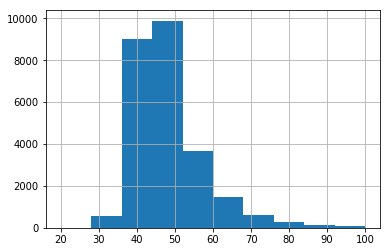

In [62]:
train_df['rebuttal_prop'].hist()
plt.show()

In [64]:
train_df[train_df.rebuttal_prop > 60][['title', 'counter', 'counter_conclusion', 'rebuttal_prop']].head(n=10)

,title,counter,counter_conclusion,rebuttal_prop
361,I believe that cyberbullying isn't a real form of bullying. ?,"people with low self esteem can have their identity tied to the perceived success of an online profile, meaning any trolling or sincere hate can be just like having someone yell in your face. that's only one example why cyber bullying is a real thing like bullying.",cyber bullying is a very real form of bullying.,88
371,"People who claim the Civil War had nothing to do with slavery are wrong,","slavery quite literally had nothing to do with the civil war. slavery was only a relevant issue to the south, who didn't start or want to fight the war in the first place. in fact, they never even invaded. slavery was a central reason why the south wanted to leave the union, but it was not at all relevant to the war. the civil war was fought because the south did not have the legal authority to leave the union, and did not first rally to hold a constitutional convention. basically what they did to the union was unconstitutional, and their action was seen as a grave threat to american national security amp; sovereignty. the civil war was fought to protect these things, to exert the sovereignty of the union over the south. it wouldn't have mattered why they wanted to leave, what matters is how they decided to leave. our constitution was a compromise signed by the founders. the american state the union is empowered by it to do anything necessary to preserve it. the south woefully underestimated the lengths that the union would go to protect it. read sherman. he'll tell you all about the civil war, and why atlanta was burned down, and how slavery had nothing to do with. who cares what the apologists down south have to say? we never forgot their treason up here :",the south had nothing to do with the civil war,65
404,"I believe that its far too easy to be a teacher, and that teachers should be masters of their fields.","ideally, yes. no one will argue about increasing experience levels of teachers. however, it isn't feasible to hire 'masters of the field'. someone who takes the time to become a master in a field expects a generous income; one that already struggling school systems cannot afford. experience isn't necessary. someone with a masters in engineering doesn't need to be teaching entry level java or pre calculus. a physicist isn't necessary to teach basic high school physics. someone with a broad teaching degree can understand the material and teach it effectively",It is not feasible to hire a master of the field,62
649,I think having 'cliques' in high school is perfectly fine.,"you don't give enough details, so i was hoping you could tell us which of these is going on:some administrators dislike 'cliques' in the negative sense i understand them: a group that walls itself off from the outside. by forcing students to go outside their walls and step outside their comfort zone, it really does help students understand their classmates better and grow as people. some administrators fear strong friend groups because those form an alternative to their power. if you can like trust good friends, then you can rely on them and that weakens teachers' power to control their students. since you say 'high school', can i assume it's the first? when i was in school, deliberately breaking up friendships was more an elementary school thing than high school, but is this still true?",i think high school is a good thing,63
654,I believe that drug tests should be mandatory to receive welfare.,"outside of it being a pretty basic violation of medical privacy, it simply isn't worth the cost. drug test are very expensive and you could help so many more families that need it with savings. also, should drug tests be mandatory for elected officials? should they be mandatory for all workers who receive any type of compensation from the government including employees and those awarded money in court ? anyone who does is receiving taxpayer money, so sho

In [65]:
print('{} Rebuttal cases of {}'.format(len(train_df[train_df.rebuttal_prop > 60]), len(train_df)))

2310 Rebuttal cases of 25704


--------

In [11]:
#First save all the data without masking..
train_df = df[df['split'] == 'train']
dev_df   = df[df['split'] == 'val']
test_df  = df[df['split'] == 'test']

#### Prepare the data for training:
- Choose top argumentative comments

In [4]:
import torch

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [13]:
from transformers import BertForSequenceClassification, AutoTokenizer, TextClassificationPipeline

#take top quality counter from the dataset!
gretz_model = BertForSequenceClassification.from_pretrained('../../../data-ceph/arguana/arg-generation/argument-quality/argument-quality-model/checkpoint-9000', local_files_only=True, cache_dir='cache')
tokenizer = AutoTokenizer.from_pretrained('bert-base-uncased', cache_dir='cache')

arg_quality_pipeline = TextClassificationPipeline(model=gretz_model, tokenizer=tokenizer, framework='pt', task='ArgQ', device=0)

In [16]:
def get_best_argumentative_comment(comments):    
    comments = [' '.join(x) for x in comments]
    # set the pipeline
    results = arg_quality_pipeline(comments, truncation=True)
    comments_scores = []
    for result_dict in results:
        comments_scores.append(result_dict['score'])
    
    comments = sorted(list(zip(comments, comments_scores)), key= lambda x: -x[1])
    return comments[0][0]

In [ ]:
post_to_comments_df = train_df.groupby('post_id').agg({'counter': lambda x: list(x)}).reset_index()
post_to_comments_df['best_comment'] = post_to_comments_df.counter.apply(lambda x: get_best_argumentative_comment(x))
post_to_best_comment = pd.Series(post_to_comments_df.best_comment.values,index=post_to_comments_df.post_id).to_dict()

In [ ]:
train_df['counter'] = train_df.post_id.apply(lambda x: post_to_best_comment[x]) #override the comments with the best one...

In [ ]:
train_df.drop_duplicates('post_id').to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/preprocessed_train_conclusion_all.pkl')

In [18]:
dev_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/valid_conclusion_all.pkl')
test_df.to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/test_conclusion_all.pkl')

In [20]:
dev_df.drop_duplicates('post_id').sample(2000).to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_valid_conclusion_all.pkl')
test_df.drop_duplicates('post_id').sample(2000).to_pickle('../../../data-ceph/arguana/arg-generation/multi-taks-counter-argument-generation/reddit_data/conclusion_and_ca_generation/sample_test_conclusion_all.pkl')